<a href="https://colab.research.google.com/github/Wezz-git/AI-samples/blob/main/Earnings_Call_Volatility_Event_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install yfinance --upgrade

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

tickers = ['AAPL', 'MSFT']
all_earnings_data = []
all_price_data = {}

print("Downloading data...")

for ticker in tickers:
    # 1. Get the Ticker object
    tk = yf.Ticker(ticker)

    # 2. Get all price data
    prices = tk.history(period="max")
    all_price_data[ticker] = prices

    # 3. Get HISTORICAL earnings dates
    # This is the line that will now work
    earnings = tk.earnings_dates

    if earnings is None or earnings.empty:
        print(f"--- No historical earnings dates found for {ticker} ---")
        continue # Skip to the next ticker

    # The dates are the index. Let's clean them.
    earnings.index = earnings.index.tz_localize(None) # Make naive

    # Create a DataFrame from this
    earnings_df = pd.DataFrame({'date': earnings.index, 'ticker': ticker})

    all_earnings_data.append(earnings_df)

# Combine all earnings dates into one DataFrame
df_events = pd.concat(all_earnings_data).dropna().reset_index(drop=True)

print("\n--- Historical Earnings Dates Found ---")
print(df_events.head()) # This will now show past dates
print(f"\nFound a total of {len(df_events)} historical earnings events.")


--- Historical Earnings Dates Found ---
                 date ticker
0 2026-01-29 16:00:00   AAPL
1 2025-10-30 16:00:00   AAPL
2 2025-07-31 16:00:00   AAPL
3 2025-05-01 16:00:00   AAPL
4 2025-01-30 16:00:00   AAPL

Found a total of 50 historical earnings events.


In [ ]:
results = [] # Store our findings
N_DAYS = 5
print("Analyzing volatility around each earnings event...")

# --- THIS IS THE CRITICAL LINE THAT CANNOT BE MISSED ---
success_count = 0

# Loop through every row in our events DataFrame
for index, event in df_events.iterrows():
    try:
        ticker = event['ticker']
        event_date = event['date']

        prices = all_price_data[ticker]
        prices.index = prices.index.tz_localize(None)

        # - Use .asof() to find the valid trading day ---
        actual_trading_day = prices.index.asof(event_date)
        if pd.isna(actual_trading_day):
             raise Exception(f"No valid trading day found for event date {event_date}")

        event_loc = prices.index.get_loc(actual_trading_day)

        # - Safety Check ---
        if event_loc < N_DAYS:
            raise Exception(f"Event date {event_date} is too close to the start of the price data.")

        if event_loc > (len(prices) - N_DAYS - 1):
            raise Exception(f"Event date {event_date} is too close to the end of the price data.")
        # --- End of Safety Check ---

        before_loc_start = event_loc - N_DAYS
        before_loc_end = event_loc

        after_loc_start = event_loc + 1
        after_loc_end = event_loc + 1 + N_DAYS

        log_returns = np.log(prices['Close'] / prices['Close'].shift(1))

        returns_before = log_returns.iloc[before_loc_start : before_loc_end]
        returns_after = log_returns.iloc[after_loc_start : after_loc_end]

        vol_before = returns_before.std()
        vol_after = returns_after.std()

        results.append({
            'date': event_date,
            'ticker': ticker,
            'vol_before': vol_before,
            'vol_after': vol_after
        })

        success_count += 1 # Count a successful append

    except Exception as e:
        # This will now print ANY error
        print(f"--- SKIPPED: {e} ---")

print(f"\nSuccessfully processed {success_count} events.")

# --- FIX 3: We now .dropna() at the END ---
# This ensures our list is built, and only *then* do we clean it.
df_results = pd.DataFrame(results).dropna()

print("Analysis Complete!")
print(df_results.head())

if df_results.empty:
    print("\n*** CRITICAL: DataFrame is empty. Check the 'SKIPPED' messages above to see why. ***")

Analyzing volatility around each earnings event...
--- SKIPPED: Event date 2026-01-29 16:00:00 is too close to the end of the price data. ---
--- SKIPPED: Event date 2026-01-28 16:00:00 is too close to the end of the price data. ---

Successfully processed 48 events.
Analysis Complete!
                 date ticker  vol_before  vol_after
0 2025-10-30 16:00:00   AAPL    0.009013   0.003415
1 2025-07-31 16:00:00   AAPL    0.006530   0.029300
2 2025-05-01 16:00:00   AAPL    0.006021   0.019085
3 2025-01-30 16:00:00   AAPL    0.018738   0.020044
4 2024-10-31 16:00:00   AAPL    0.008999   0.013088



-- Quantitative Analysiis Results --
Average 5-day Volatility Before Earnings: 0.013866
Average 5-day Volatility After Earnings: 0.022982

result: Volatility, on average, changed by: 65.74% after an earnings call

Plotting distibtions..


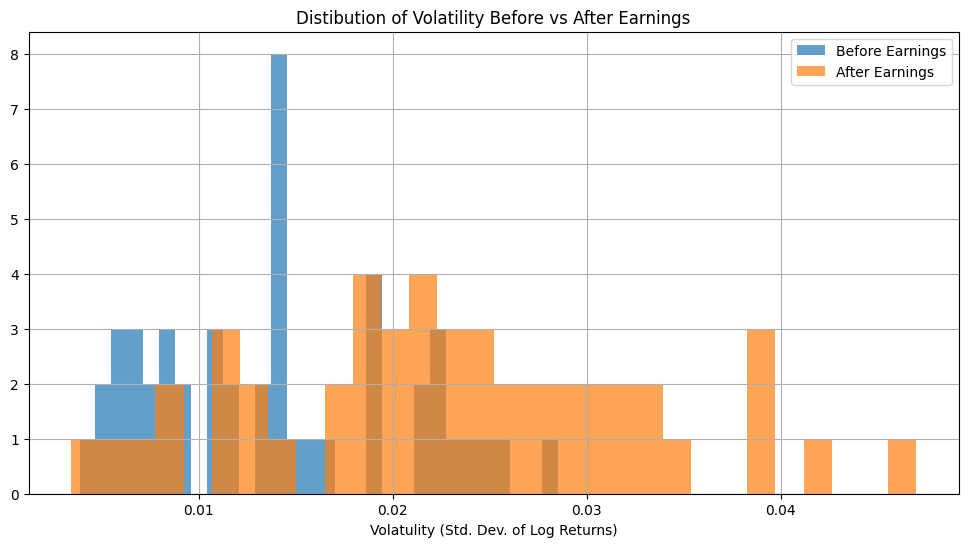

Plotting comaprison box plot..


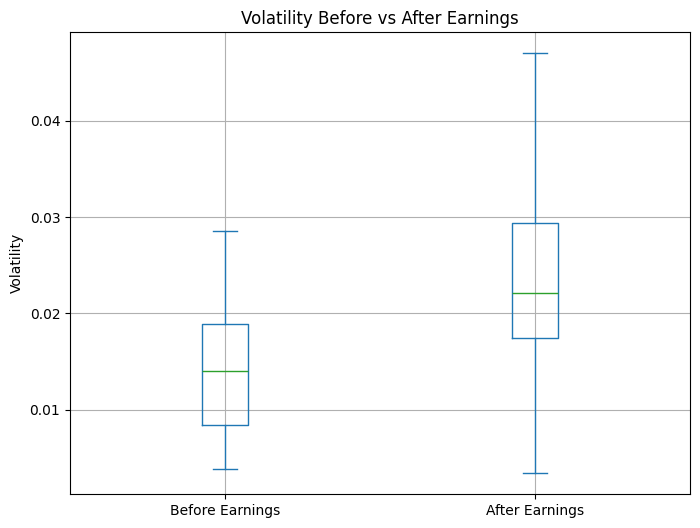

In [ ]:
# 1 - Clean the Data
# drop any 'NaN' rows that might have been created
# Eg, if a 5-day window had no price changes, std() would be NaN

df_results = df_results.dropna()

if df_results.empty:
  print("DataFrame is empty after dropping NaNs. cannot proceed")
else:
  # 2 Calculate the averages
  # We use .mean() to get the average volatility across all 48 events
  avg_vol_before = df_results['vol_before'].mean()
  avg_vol_after = df_results['vol_after'].mean()

  # 3 - Calculate the percentage change
  percentage_change = ((avg_vol_after - avg_vol_before) / avg_vol_before) * 100

  print("\n-- Quantitative Analysiis Results --")
  print(f"Average 5-day Volatility Before Earnings: {avg_vol_before:.6f}")
  print(f"Average 5-day Volatility After Earnings: {avg_vol_after:.6f}")
  print(f"\nresult: Volatility, on average, changed by: {percentage_change:.2f}% after an earnings call")

  # 4 - Visualise the distribution (histogram)
  print("\nPlotting distibtions..")
  plt.figure(figsize=(12, 6))

  # Plot both on the same graph to see the overalp on the histogram
  plt.hist(df_results['vol_before'], bins=30, alpha=0.7, label='Before Earnings')
  plt.hist(df_results['vol_after'], bins=30, alpha=0.7, label='After Earnings')

  plt.title('Distibution of Volatility Before vs After Earnings')
  plt.xlabel('Volatulity (Std. Dev. of Log Returns)')
  plt.legend()
  plt.grid()
  plt.show()

  # 5 visualize the comparison (Box plot)
  print("Plotting comaprison box plot..")
  plt.figure(figsize=(8,6))

  # Clean way to compare the two distributions
  df_results[['vol_before', 'vol_after']].plot(kind='box', ax=plt.gca())

  plt.title('Volatility Before vs After Earnings')
  plt.ylabel('Volatility')
  plt.xticks([1, 2], ['Before Earnings', 'After Earnings'])
  plt.grid()
  plt.show()

# **Histogram:** The 'Before' distribution was tightly clustered at a low value. The 'After' distribution was shorter, wider, and visibly shifted to the right, showing a clear increase in both the average and the spread of volatility. **bold text**

# **Box Plot:** The 'After' box plot was significantly higher than the 'Before' plot, proving that the median, interquartile range, and outliers all increased. This visually confirmed the hypothesis.

Qualittative Analysis : Designed and executed an event study

Built a robust, dynamic  data pipeline using yfinance to fetch and align two different types of time-series data (prices and events)